In [1]:
import torch
import os
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from mini_imagenet_dataset import MiniImageNetDataset


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# if torch.backends.mps.is_available():
#     device = torch.device("mps")
# else:
#     print("MPS device not found.")
# print('Device:', device)


In [3]:
train_dataset = MiniImageNetDataset(root_dir=os.getcwd(), phase='train', shuffle_images=True, transform=None, start_class=0)

val_dataset = MiniImageNetDataset(root_dir=os.getcwd(), phase='val', shuffle_images=True, transform=None, start_class=64)

test_dataset = MiniImageNetDataset(root_dir=os.getcwd(), phase='test', shuffle_images=True, transform=None, start_class=80)

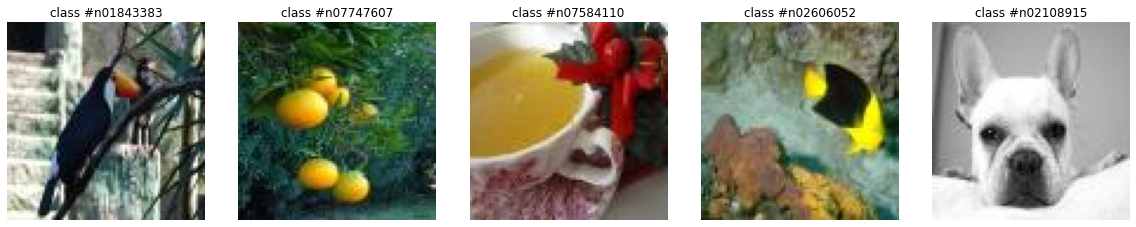

total number of training set: 38400


In [4]:
idx = np.random.choice(range(len(train_dataset)), 5, replace=False) # randomly pick 5 pictures to show

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = train_dataset[idx[i]]
    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(train_dataset.class_mapping[label]))
    ax.axis('off')
    plt.imshow(np.asarray(image))

plt.show()

# print number of images for each class
print('total number of training set: {}'.format(len(train_dataset)))
# for i in range(len(train_dataset.label_names)):
#     print('numer of images for class {}: {}'.format(train_dataset.label_names[i], len([label for _, label in train_dataset.data if label == train_dataset.label_names[i]])))

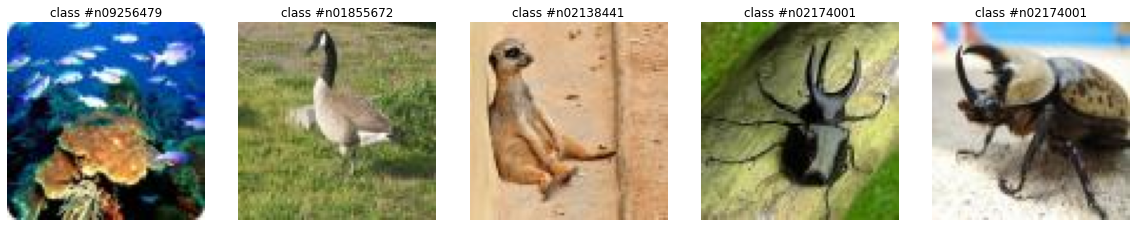

total number of val set: 9600


In [5]:
idx = np.random.choice(range(len(val_dataset)), 5, replace=False) # randomly pick 5 pictures to show

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = val_dataset[idx[i]]
    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(val_dataset.class_mapping[label]))
    ax.axis('off')
    plt.imshow(np.asarray(image))

plt.show()

# print number of images for each class
print('total number of val set: {}'.format(len(val_dataset)))
# for i in range(len(val_dataset.label_names)):
#     print('numer of images for class {}: {}'.format(val_dataset.label_names[i], len([label for _, label in val_dataset.data if label == val_dataset.label_names[i]])))

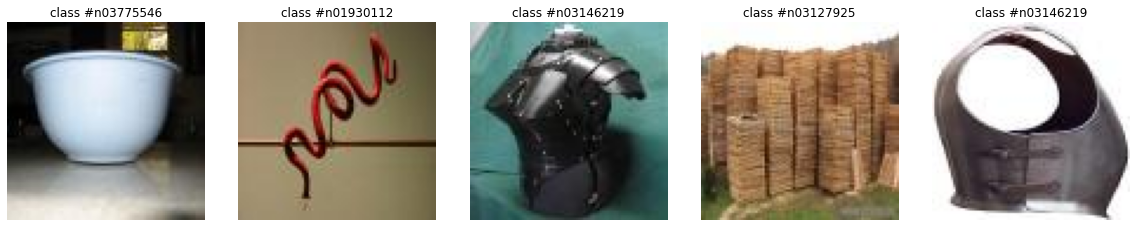

total number of test set: 12000


In [6]:
idx = np.random.choice(range(len(test_dataset)), 5, replace=False) # randomly pick 5 pictures to show

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = test_dataset[idx[i]]
    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(test_dataset.class_mapping[label]))
    ax.axis('off')
    plt.imshow(np.asarray(image))

plt.show()

# print number of images for each class
print('total number of test set: {}'.format(len(test_dataset)))
# for i in range(len(test_dataset.label_names)):
#     print('numer of images for class {}: {}'.format(test_dataset.label_names[i], len([label for _, label in test_dataset.data if label == test_dataset.label_names[i]])))

In [7]:
batch_size = 64
num_workers = 4
learning_rate = 0.001
num_epochs = 10

transform = transforms.Compose([transforms.Resize((84, 84)),
                                transforms.ToTensor()])

train_dataset = MiniImageNetDataset(root_dir=os.getcwd(), phase='train', shuffle_images=True, transform=transform, start_class=0)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_dataset = MiniImageNetDataset(root_dir=os.getcwd(), phase='val', shuffle_images=True, transform=transform, start_class=64)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

test_dataset = MiniImageNetDataset(root_dir=os.getcwd(), phase='test', shuffle_images=True, transform=transform, start_class=80)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [8]:
from torchvision.models import resnet18
import torch.nn as nn

class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.resnet18 = resnet18(pretrained=False)
        in_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet18(x)

In [9]:
batch_size = 64
num_workers = 4
learning_rate = 0.001
num_epochs = 10

# Instantiate the model
model = ResNet18(num_classes=100).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        print(f'Epoch: {epoch + 1}, Loss: {loss.item()}', end='\r')

    average_loss = total_loss / len(train_loader)
    print(f'Training Loss: {average_loss}')

# Validation loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, labels in validation_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Validation Accuracy: {accuracy * 100}%')

# Test loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100}%')

/Users/nipunwaas/miniforge3/envs/pytorch_/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nipunwaas/miniforge3/envs/pytorch_/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


KeyboardInterrupt: 